## Project: Estimation of accuracy of MOI for MVCs 
Created by: Thomas Hartka, MD, MSDS  
Date created: 1/15/22
  
This notebook analyzes determines the AUC for the existing MOI criteria for early (2000-2009) and late (2010-2019) decades.

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import scipy.stats as st
import matplotlib.pyplot as plt
from itertools import combinations
import datetime
from multiprocessing import Process, Queue
import multiprocessing
import moi_analysis as moi

## Parameters

In [2]:
mvcs_data_file = "../Data/NASS_CISS-2000_2019-unfiltered.csv"
mvcs_imp_data_file = "../Data/NASS_CISS-2000_2019-imputated.csv"

In [3]:
use_imputed = True  # whether to use imputed or raw data
bootstrap_div = 5   # divisor of full sample len for bootstrapped sample
bootstrap_num = 1000   # number of bootstrapped samples

In [4]:
# column names
outcome = 'iss16'
existing_cit = ['int12occ','int18','ejection','other_death']
case_weights = 'casewgt'

## Read in data

In [5]:
if use_imputed:
    # use imputated data set
    mvcs = pd.read_csv(mvcs_imp_data_file)

else:
    # use unimputed data set
    mvcs = pd.read_csv(mvcs_data_file)

In [6]:
# separate crashes by decade
mvcs_2000_2009 = mvcs[mvcs.year<=2009].copy()
mvcs_2010_2019 = mvcs[mvcs.year>=2010].copy()

In [10]:
# separate crashes by decade
mvcs_2000_2009 = mvcs[mvcs.year<=2009].copy()
mvcs_2010_2019 = mvcs[mvcs.year>=2010].copy()

## Calculate bootstrapped estimates

In [11]:
# set seed for reproducibility
np.random.seed(42)

In [12]:
# calculate size of each bootstrap sample
sample_size = round(len(mvcs)/bootstrap_div)

In [13]:
%%time
# calcuate results for 2000-2009
res_early = moi.auc_bootstrap(mvcs_2000_2009, existing_cit, outcome, sample_size, bootstrap_num, verbose=True)

Sample:  0  of  1000
Sample:  100  of  1000
Sample:  200  of  1000
Sample:  300  of  1000
Sample:  400  of  1000
Sample:  500  of  1000
Sample:  600  of  1000
Sample:  700  of  1000
Sample:  800  of  1000
Sample:  900  of  1000
CPU times: user 8min 32s, sys: 1min 12s, total: 9min 45s
Wall time: 9min 11s


In [14]:
%%time
# calcuate results for 2010-2019
res_late = moi.auc_bootstrap(mvcs_2010_2019, existing_cit, outcome, sample_size, bootstrap_num, verbose=True)

Sample:  0  of  1000
Sample:  100  of  1000
Sample:  200  of  1000
Sample:  300  of  1000
Sample:  400  of  1000
Sample:  500  of  1000
Sample:  600  of  1000
Sample:  700  of  1000
Sample:  800  of  1000
Sample:  900  of  1000
CPU times: user 8min 7s, sys: 32.1 s, total: 8min 39s
Wall time: 8min 5s


In [15]:
# get median and 95% CI
med_early, ci_early = moi.med_ci(res_early)
med_late, ci_late = moi.med_ci(res_late)

## Plot ROC curse

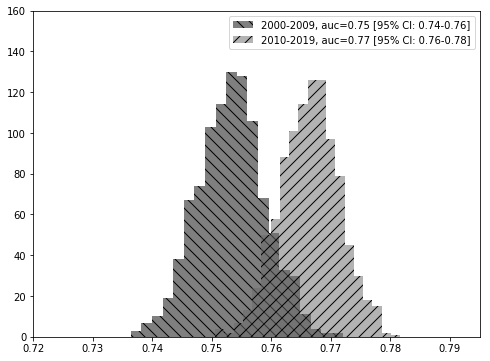

In [20]:
# plot probablity distributions
sig_dig = 2
bin_num = 20

ax = plt.figure(0)

# add results for early (2000-2009)
plt.hist(res_early, alpha=0.5, color='black',  hatch='\\\\',bins=bin_num, \
         label="2000-2009, auc="+str(round(med_early,sig_dig))+" [95% CI: "+str(round(ci_early[0],sig_dig))+\
         "-"+str(round(ci_early[1],sig_dig))+"]")

# add results for early (2010-2019)
plt.hist(res_late, alpha=0.5, color='dimgrey', hatch='//',bins=bin_num, \
         label="2010-2019, auc="+str(round(med_late,sig_dig))+" [95% CI: "+str(round(ci_late[0],sig_dig))+\
         "-"+str(round(ci_late[1],sig_dig))+"]")

# zoom in on up-slope of ROC curve
plt.xlim(0.72,0.795)
plt.ylim(0,160)

ax.set_size_inches(8,6)

plt.legend(loc='upper right')

In [17]:
# test for signfic
st.mannwhitneyu(res_early, res_late)

MannwhitneyuResult(statistic=41951.0, pvalue=6.782169325546255e-276)

## Plot ROC 

In [18]:
# get ROC results for early and late crashes
auc1, res1, tpr1, fpr1 = moi.vars_auc(mvcs_2000_2009, existing_cit, outcome, case_weights, verbose=True)
auc2, res2, tpr2, fpr2 = moi.vars_auc(mvcs_2010_2019, existing_cit, outcome, case_weights, verbose=True)

['int12occ']
['int12occ', 'int18']
['int12occ', 'int18', 'ejection']
['int12occ', 'int18', 'ejection', 'other_death']
['int12occ']
['int12occ', 'int18']
['int12occ', 'int18', 'ejection']
['int12occ', 'int18', 'ejection', 'other_death']


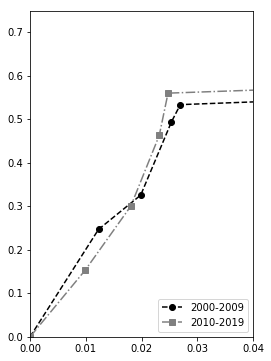

In [19]:
ax = plt.figure(0)

# add results for early (2000-2009)
plt.plot(fpr1,tpr1,linestyle='--', marker='o', color='black',label="2000-2009")

# add results for early (2010-2019)
plt.plot(fpr2,tpr2,linestyle='-.', marker='s', color='grey',label="2010-2019")

plt.ylim(0,0.75)
plt.xlim(0,0.04)

ax.set_size_inches(4,6)

plt.legend(loc='lower right')